# Capstone Proyek : Sistem Rekomendasi Tanaman Berdasarkan Lokasi User

## Data Understanding

### Import Library

In [ ]:
# ==============================
# 📦 Import Library yang Dibutuhkan
# ==============================

# --- General Libraries ---
import numpy as np
import pandas as pd
import joblib

# --- Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 🤖 Machine Learning Libraries
# =============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# ==============================
# 🧠 Deep Learning (TensorFlow / Keras)
# ==============================
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import kagglehub

### Loading Dataset

Menggunakan dataset dari Kaggle: [Crop Recommendation Dataset](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset)

In [ ]:
# Download latest version
path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/crop-recommendation-dataset


In [ ]:
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
# Menghitung rata-rata kolom N dan ph
mean_N = df['N'].mean()
mean_ph = df['ph'].mean()

print(f"Rata-rata N: {mean_N}")
print(f"Rata-rata pH: {mean_ph}")

Rata-rata N: 54.21018418201517
Rata-rata pH: 6.493356854328819


In [ ]:
# Tinjau jumlah baris dan kolom dalam dataset
print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")

Jumlah baris: 2200, Jumlah kolom: 8


## Exploratory Data Analysis - Deskripsi Variabel

Exploratory Data Analysis (EDA) adalah proses awal dalam analisis data yang bertujuan untuk memahami struktur, pola, serta mendapatkan insight dari dataset. Salah satu langkah pertama dalam EDA adalah mendeskripsikan variabel, yaitu mengenali arti dan tipe data dari setiap kolom dalam dataset.

Melalui perintah df.info(), kita dapat melihat informasi ringkas mengenai struktur data:
- `N` (int): Rasio kandungan Nitrogen dalam tanah
- `P` (int): Rasio kandungan Phosphor dalam tanah
- `K` (int): Rasio kandungan Kalium (Potassium) dalam tanah
- `temperature` (float): Suhu lingkungan dalam derajat Celsius
- `humidity` (float): Kelembaban relatif dalam persen (%)
- `ph` (float): Nilai pH tanah
- `rainfall` (float): Curah hujan dalam milimeter (mm)
- `label` (object): Jenis tanaman yang direkomendasikan berdasarkan kondisi lingkungan dan tanah

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


Dari output terlihat bahwa
- Terdapat 3 kolom numerik dengan tipe data int64, di antaranya: `N`, `P`, dan `K`.
- Terdapat 4 kolom numerik dengan tipe data float64, yaitu: `temperature`, `humidity`, `ph`, dan `rainfall`.
- Terdapat 1 kolom dengan tipe data object yang berisi data kategorikal, yaitu: `label`

In [ ]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


Fungsi describe() memberikan informasi statistik pada masing-masing kolom, antara lain:

- `Count`  adalah jumlah sampel pada data.
- `Mean` adalah nilai rata-rata.
- `Std` adalah standar deviasi.
- `Min` yaitu nilai minimum setiap kolom.
- `25%` adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- `50%` adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
- `75%` adalah kuartil ketiga.
- `Max` adalah nilai maksimum.

## Exploratory Data Analysis - Menangani Missing Value & Outliers

### Menangani Missing Value

Pada tahap ini, kita akan mengidentifikasi dan menangani nilai-nilai yang hilang (missing values) dalam dataset.

In [ ]:
# Mengecek jumlah data duplikat
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


In [ ]:
# Cek missing value
df.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


### Menangani Outliers

Outliers adalah data yang memiliki nilai sangat berbeda dari sebagian besar data lainnya. Salah satu metode untuk mendeteksi outliers adalah menggunakan IQR (Interquartile Range). Data yang berada di luar rentang Q1 - 1.5 * IQR hingga Q3 + 1.5 * IQR dianggap sebagai outliers.

Jumlah data sebelum proses penanganan outlier: 2200


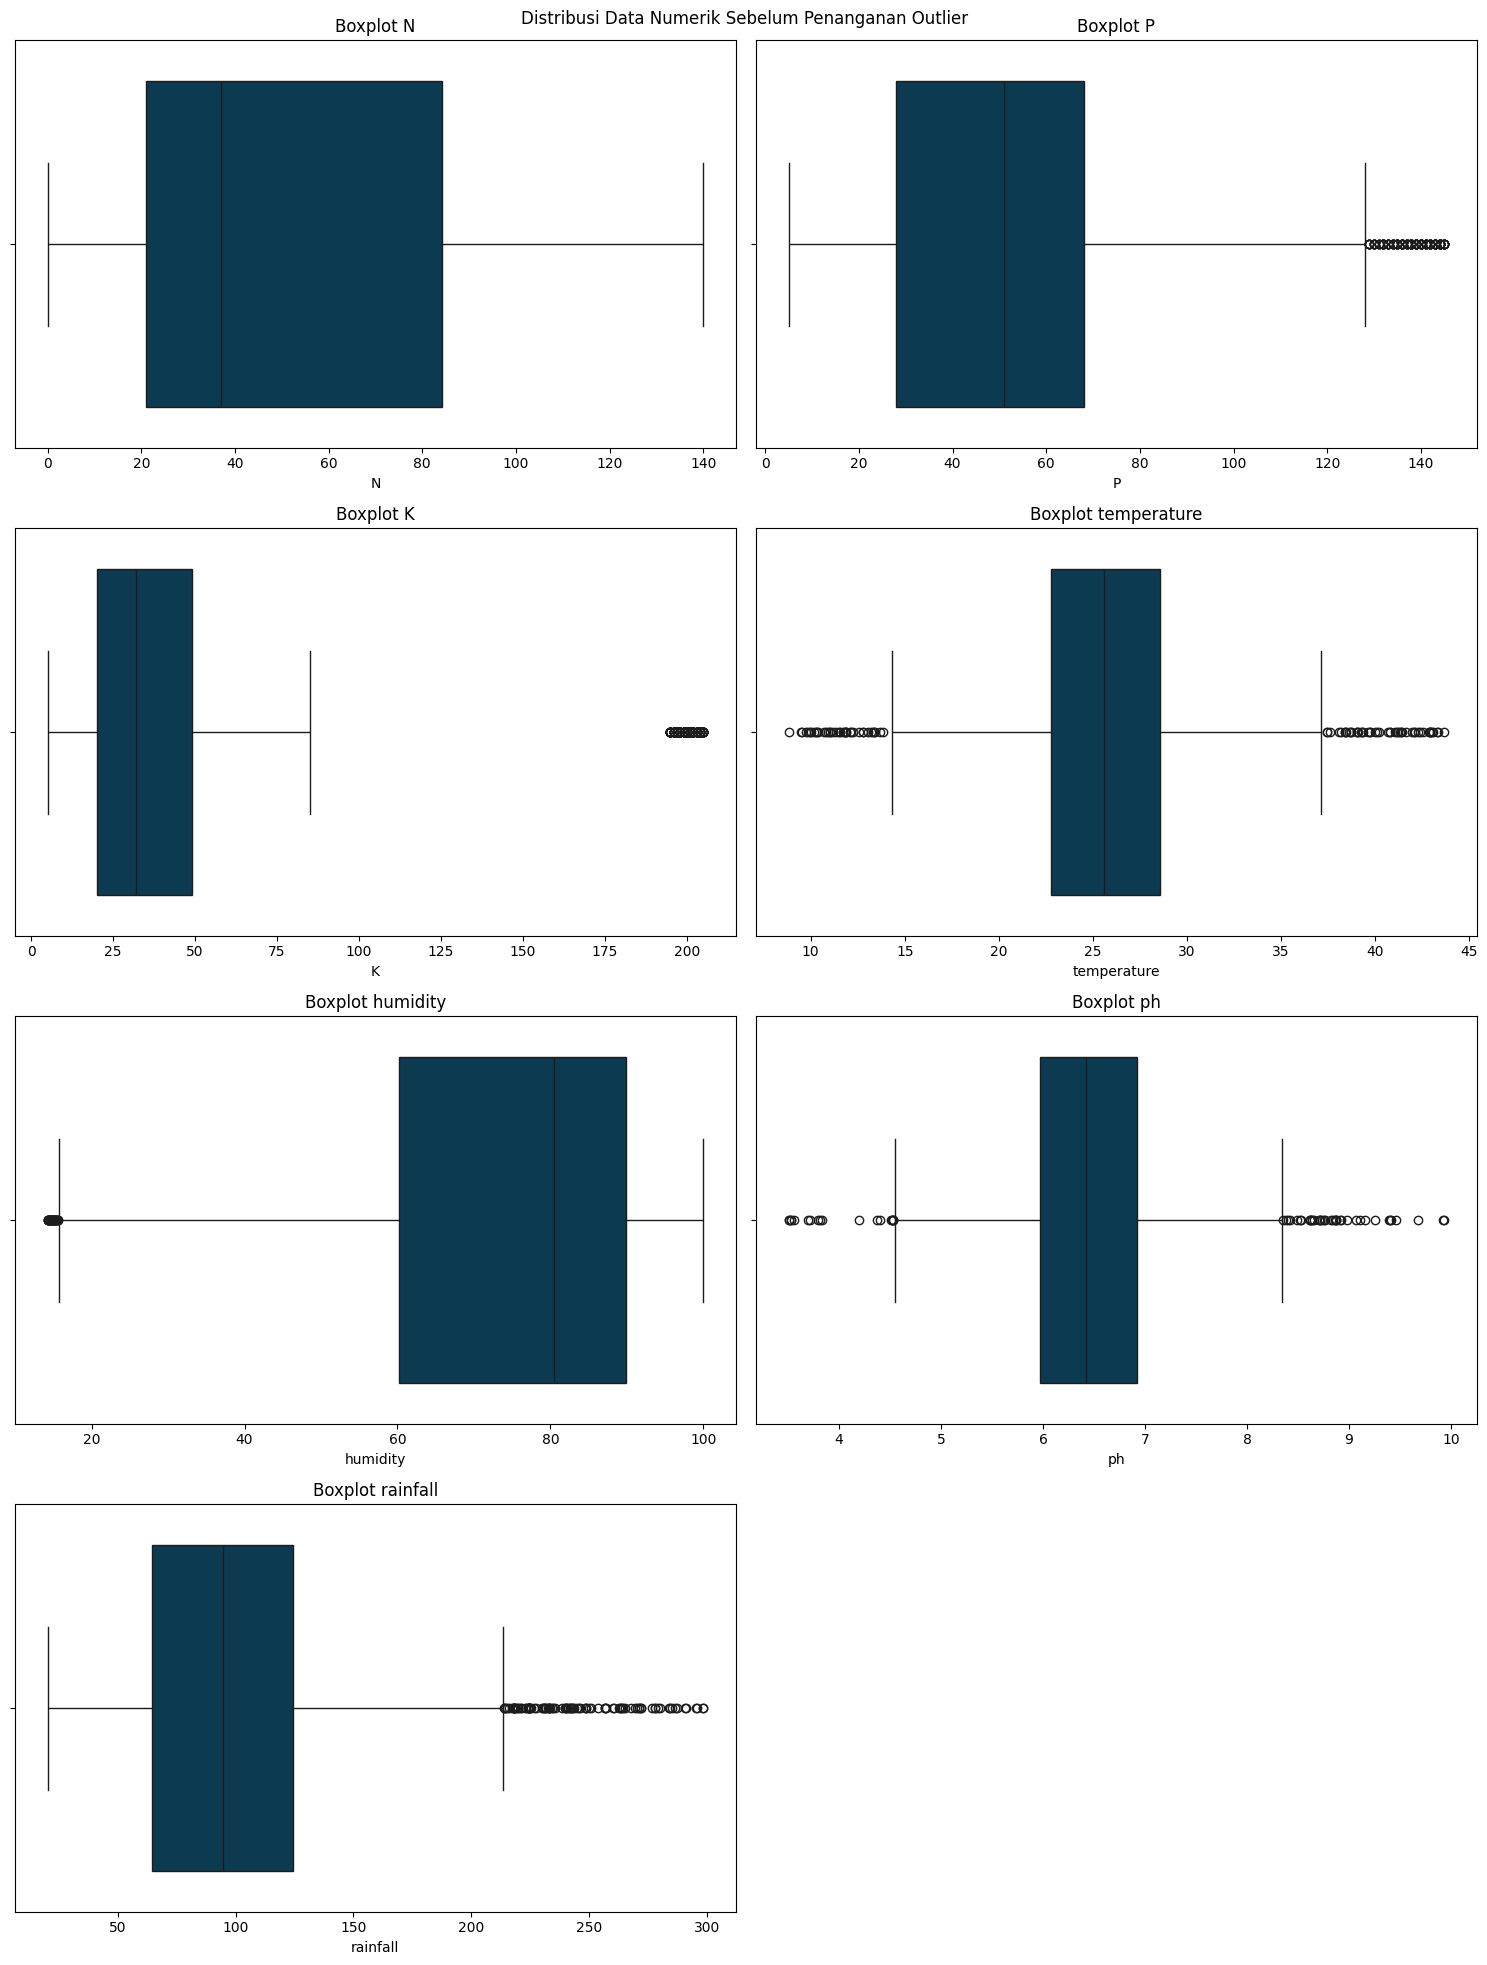

In [ ]:
# Menentukan kolom numerik untuk analisis outlier
numeric_columns = df.select_dtypes(include=['number']).columns

print(f"Jumlah data sebelum proses penanganan outlier: {df.shape[0]}")

# Menentukan jumlah baris dan kolom untuk visualisasi
n_cols = 2 # Jumlah kolom pada subplot
n_rows = (len(numeric_columns) // n_cols) + (1 if len(numeric_columns) % n_cols != 0 else 0)  # Menyesuaikan jumlah baris

# Visualisasi boxplot sebelum menghapus outlier
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Meratakan axes agar mudah diakses
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='#003f5c')
    axes[i].set_title(f'Boxplot {col}')

# Menghapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribusi Data Numerik Sebelum Penanganan Outlier")
plt.tight_layout()
plt.show()

Jumlah data setelah proses penghapusan outlier: 1846


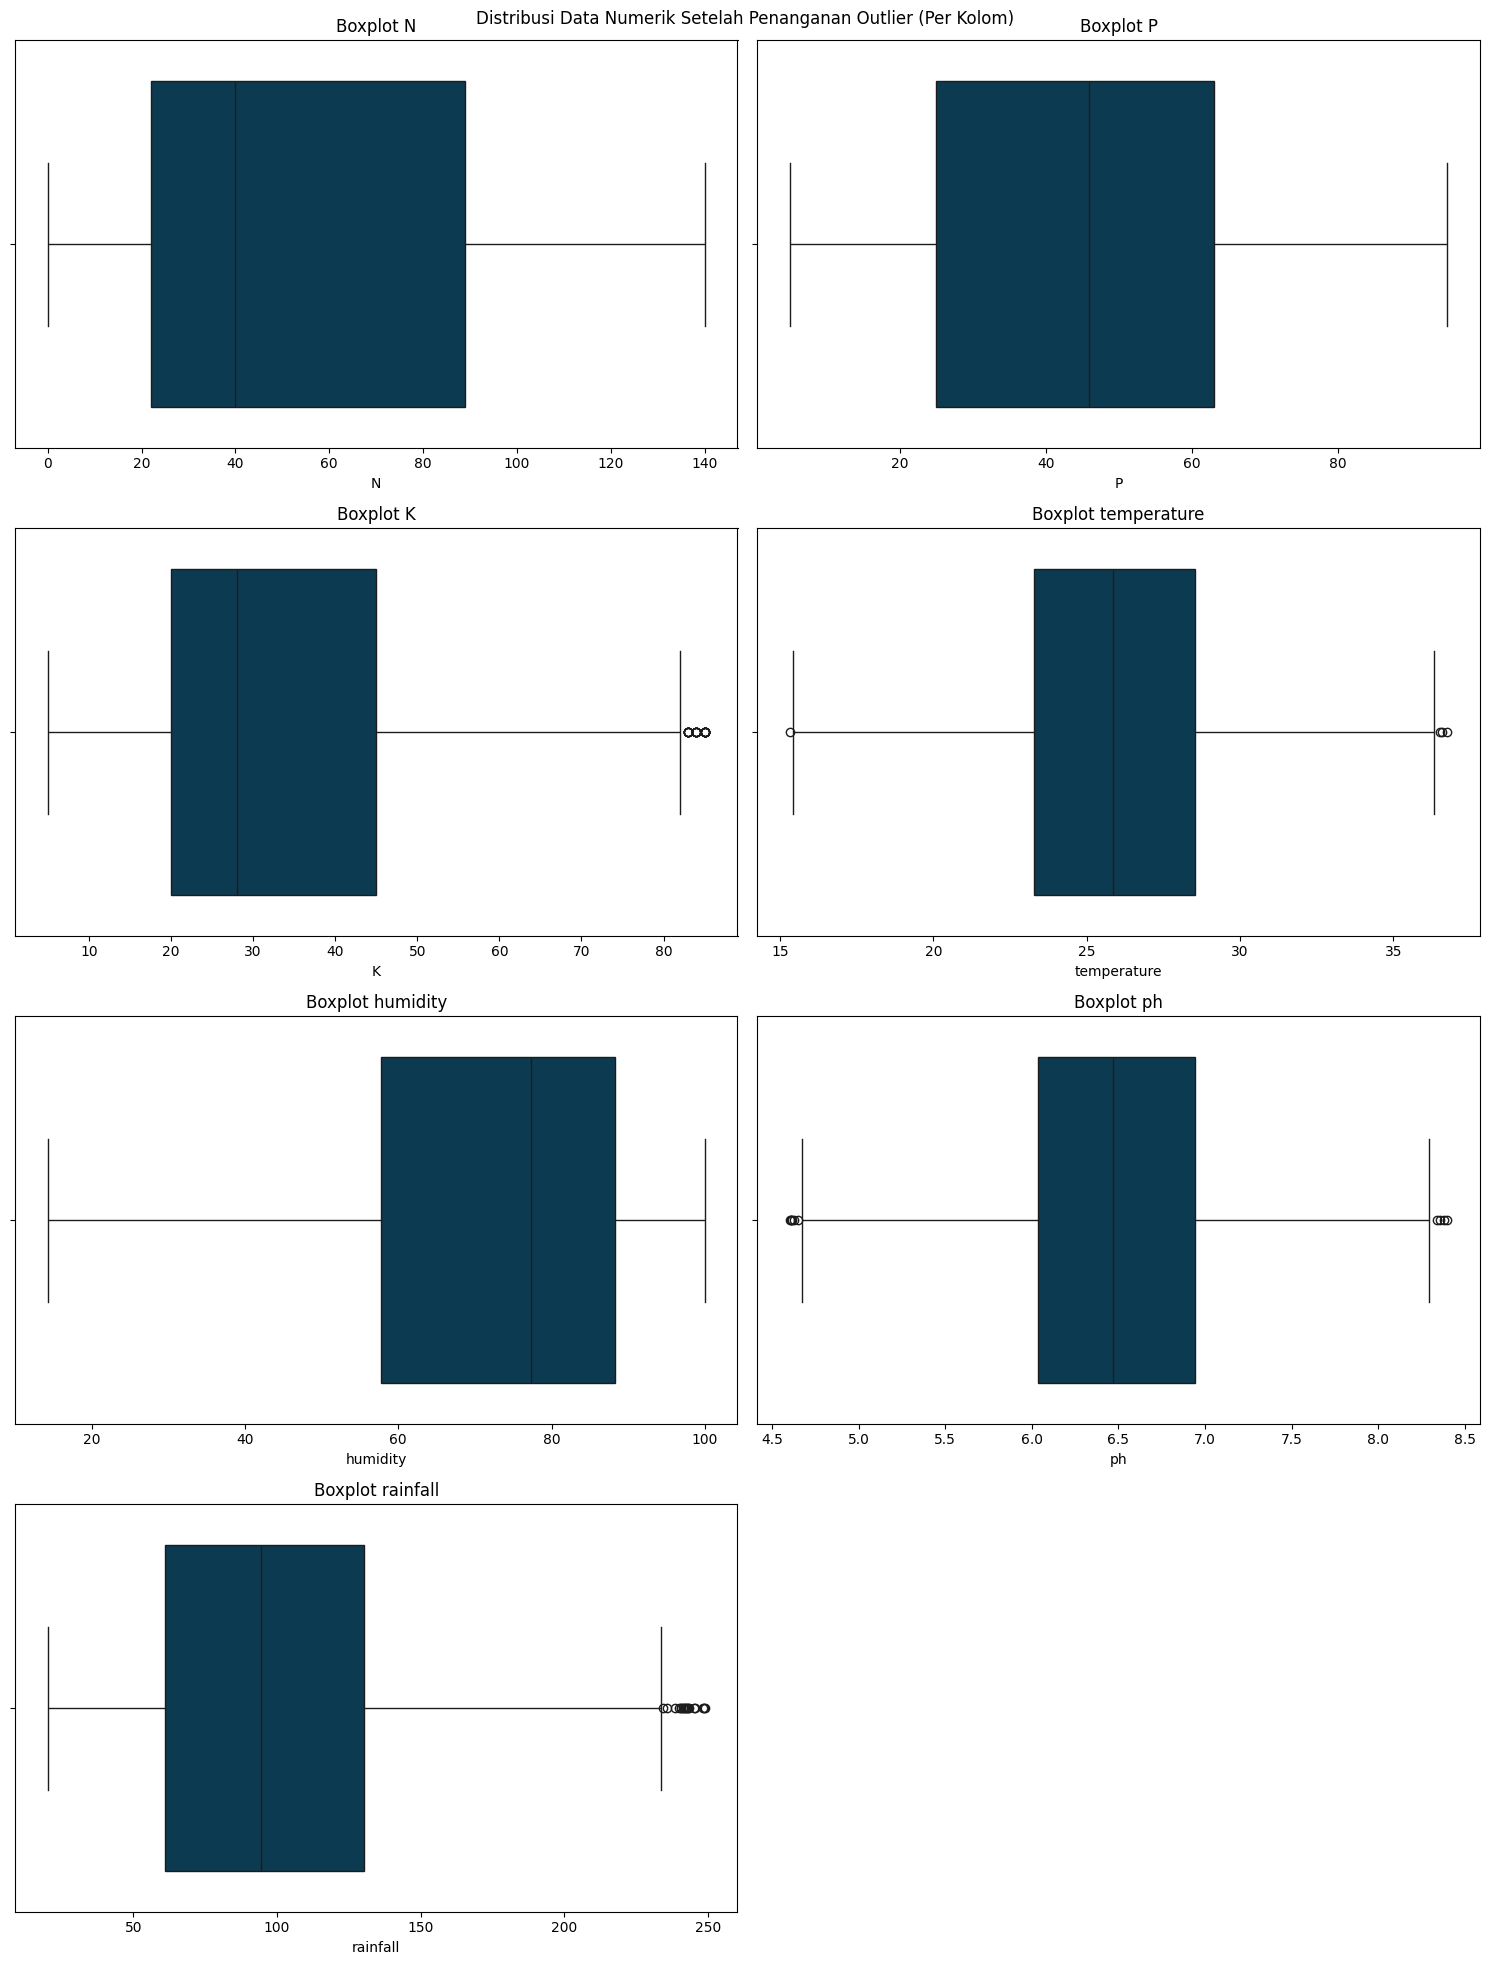

In [ ]:
# Penanganan outlier per kolom menggunakan IQR
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter nilai yang berada di dalam batas IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Jumlah data setelah proses penghapusan outlier:", df.shape[0])

# Menentukan jumlah baris dan kolom untuk visualisasi boxplot
n_cols = 2
n_rows = (len(numeric_columns) // n_cols) + (1 if len(numeric_columns) % n_cols != 0 else 0)

# Membuat visualisasi boxplot setelah penanganan outlier
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='#003f5c')
    axes[i].set_title(f'Boxplot {col}')

# Menghapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribusi Data Numerik Setelah Penanganan Outlier (Per Kolom)")
plt.tight_layout()
plt.show()

## Exploratory Data Analysis - Univariate Analysis

Selanjutnya, kita akan melakukan analisis data menggunakan teknik Univariate EDA. Langkah pertama adalah membagi fitur dalam dataset menjadi dua kategori, yaitu fitur numerik dan fitur kategorikal.

In [ ]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

### Categorical Features

Statistik untuk fitur label:
             Jumlah Sampel  Persentase
label                                 
maize                  100        5.42
kidneybeans            100        5.42
mungbean               100        5.42
blackgram              100        5.42
jute                   100        5.42
coffee                 100        5.42
pomegranate            100        5.42
lentil                 100        5.42
banana                 100        5.42
cotton                 100        5.42
muskmelon              100        5.42
watermelon             100        5.42
coconut                100        5.42
pigeonpeas              96        5.20
mango                   96        5.20
chickpea                88        4.77
orange                  81        4.39
papaya                  63        3.41
rice                    62        3.36
mothbeans               60        3.25



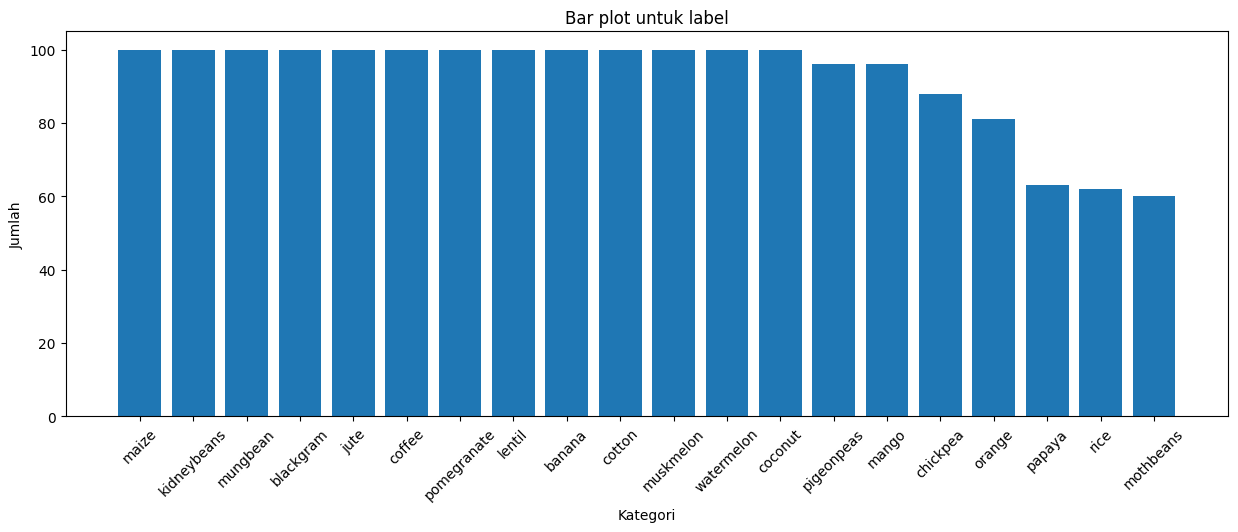

In [ ]:
for feature in categorical_features:
    # Menghitung jumlah dan persentase setiap kategori
    count = df[feature].value_counts()
    percent = df[feature].value_counts(normalize=True) * 100

    # Membuat DataFrame untuk menampilkan statistik
    stats_df = pd.DataFrame({'Jumlah Sampel': count, 'Persentase': percent.round(2)})

    # Menampilkan statistik
    print(f"Statistik untuk fitur {feature}:\n{stats_df}\n")

    # Visualisasi dengan bar plot
    plt.figure(figsize=(15, 5))
    plt.bar(count.index, count.values)
    plt.title(f"Bar plot untuk {feature}")
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.show()

### Numerical Features

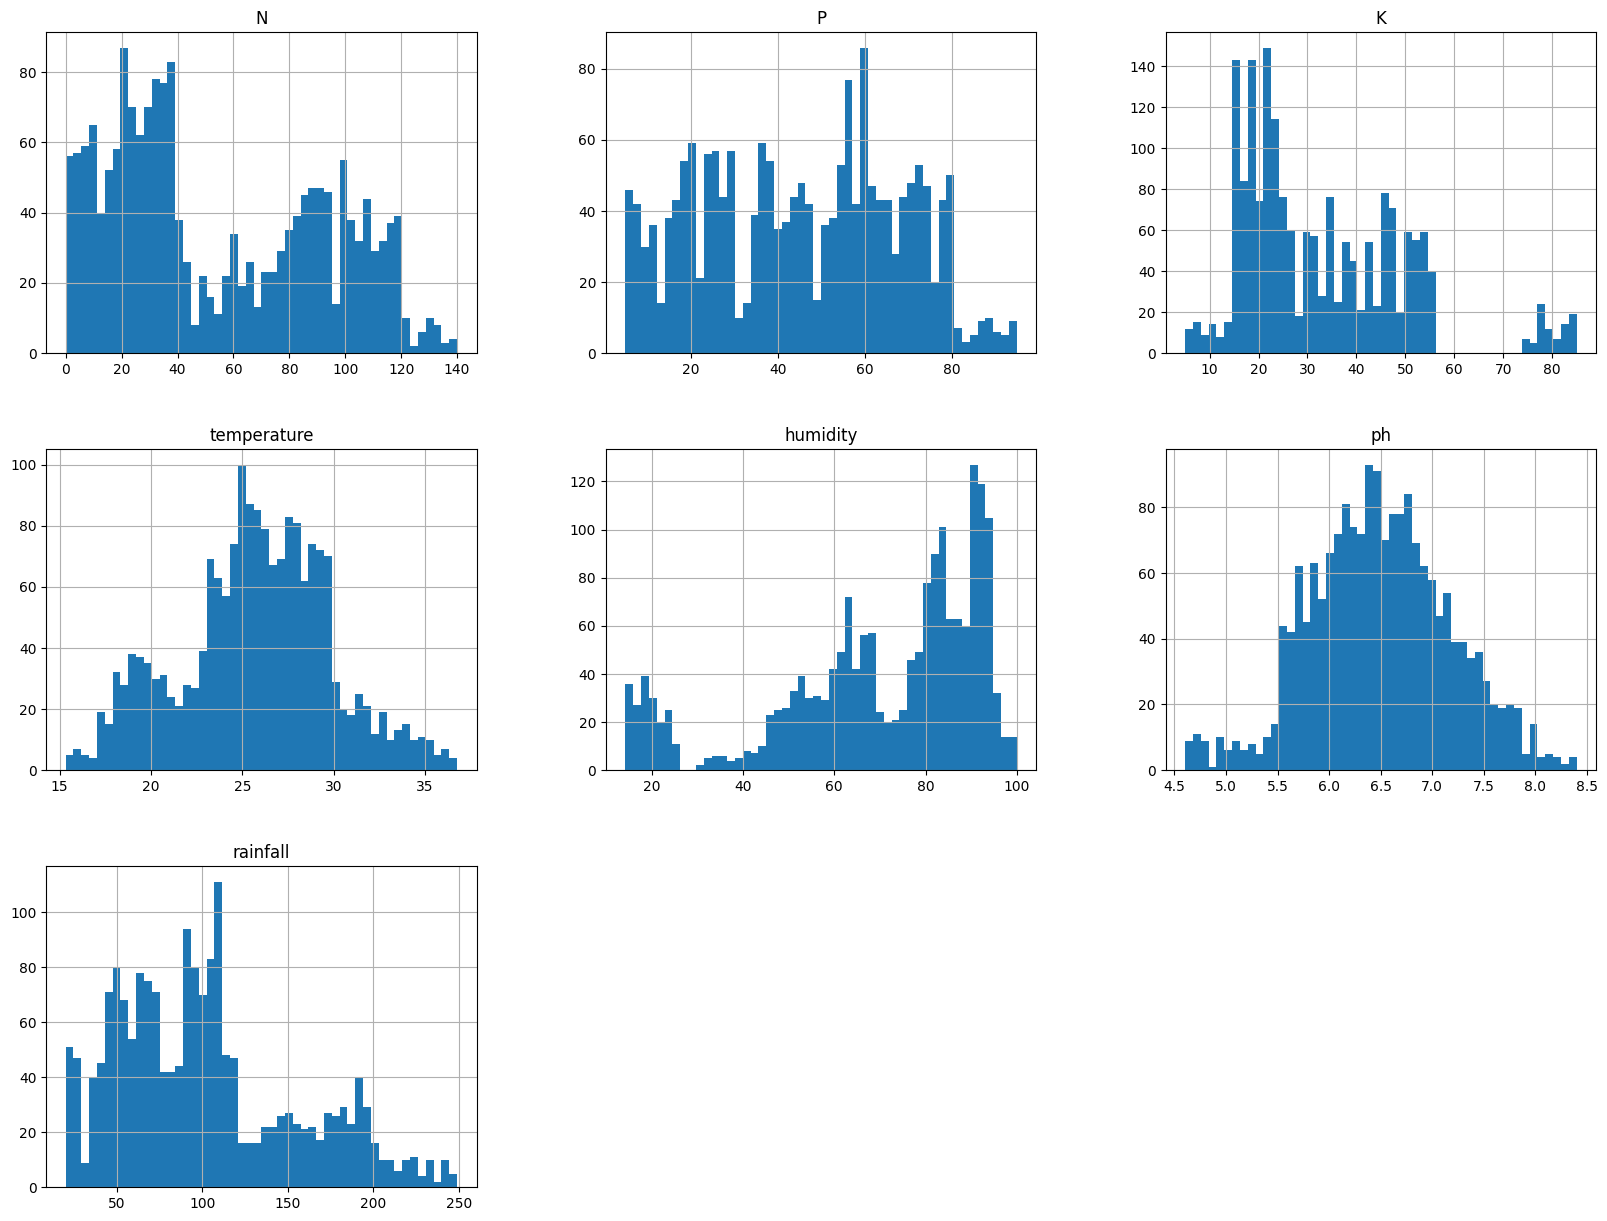

In [ ]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

## Exploratory Data Analysis - Multivariate Analysis

Multivariate EDA menunjukkan hubungan antara dua atau lebih variabel pada data. Multivariate EDA yang menunjukkan hubungan antara dua variabel biasa disebut sebagai bivariate EDA. Selanjutnya, kita akan melakukan analisis data pada fitur kategori dan numerik.

### Numerical Features

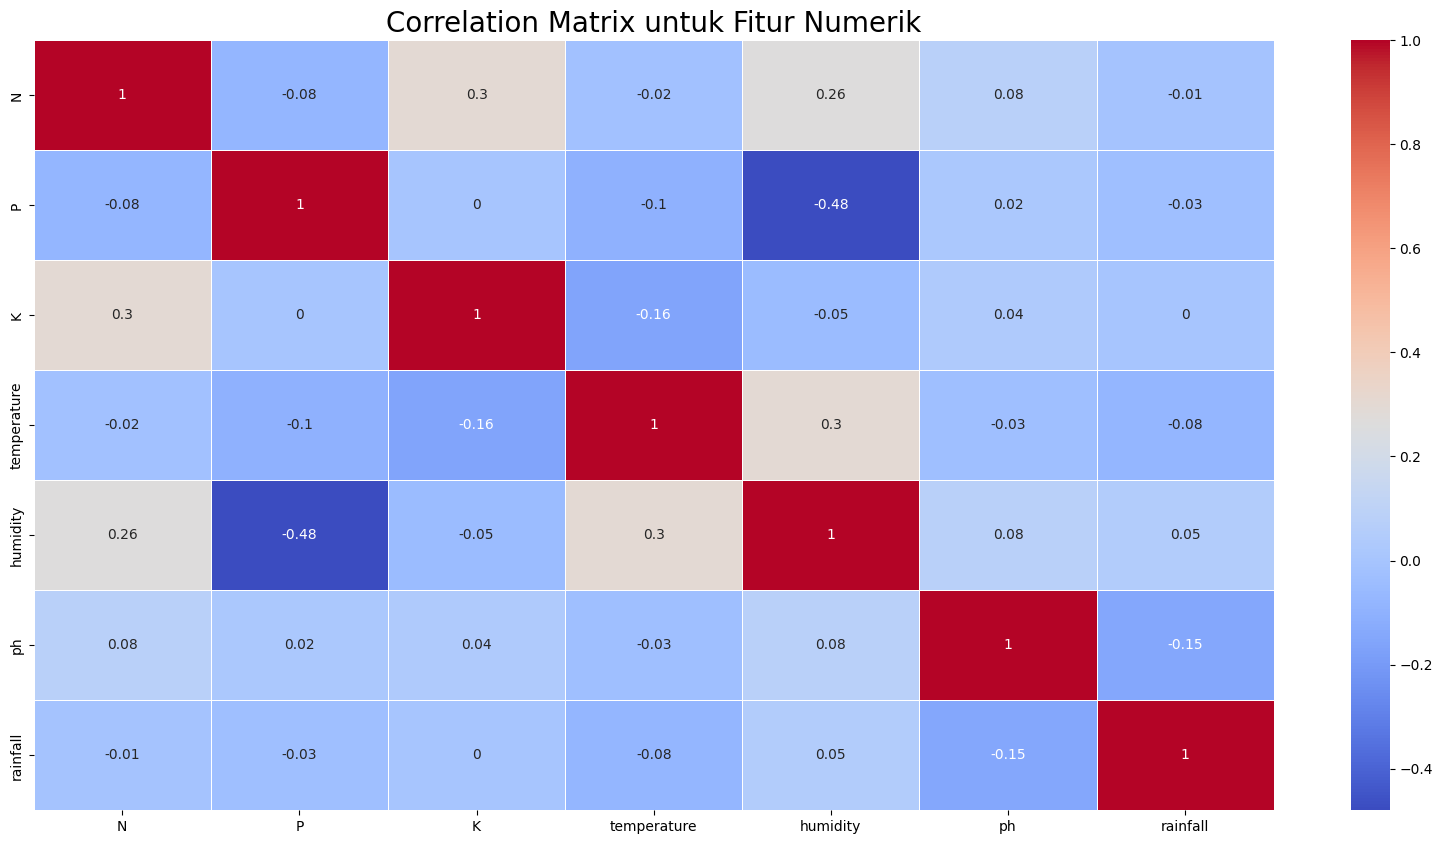

In [ ]:
# Seleksi hanya kolom numerik
numeric_features = df.select_dtypes(include=['number'])

# Hitung correlation matrix hanya untuk data numerik
correlation_matrix = numeric_features.corr().round(2)

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix untuk Fitur Numerik", size=20)
plt.show()

## Data Preparation / Preprocessing

In [ ]:
# Drop kolom yang tidak dibutuhkan untuk analisis
df = df.drop(columns=['P', 'K'])
df.head()

,N,temperature,humidity,ph,rainfall,label
0,90,20.879744,82.002744,6.502985,202.935536,rice
1,85,21.770462,80.319644,7.038096,226.655537,rice
3,74,26.491096,80.158363,6.980401,242.864034,rice
7,94,20.277744,82.894086,5.718627,241.974195,rice
8,89,24.515881,83.535216,6.685346,230.446236,rice


In [ ]:
# Encode fitur kategorikal dan target
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

df.head()

,N,temperature,humidity,ph,rainfall,label,label_encoded
0,90,20.879744,82.002744,6.502985,202.935536,rice,18
1,85,21.770462,80.319644,7.038096,226.655537,rice,18
3,74,26.491096,80.158363,6.980401,242.864034,rice,18
7,94,20.277744,82.894086,5.718627,241.974195,rice,18
8,89,24.515881,83.535216,6.685346,230.446236,rice,18


In [ ]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Menampilkan 5 baris pertama X
X.head()

,N,temperature,humidity,ph,rainfall
0,90,20.879744,82.002744,6.502985,202.935536
1,85,21.770462,80.319644,7.038096,226.655537
3,74,26.491096,80.158363,6.980401,242.864034
7,94,20.277744,82.894086,5.718627,241.974195
8,89,24.515881,83.535216,6.685346,230.446236


In [ ]:
# Buat instance StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=69)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(1476, 5), y_train=(1476,)
Test set shape: X_test=(370, 5), y_test=(370,)


In [ ]:
# Definisikan EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss', # Pantau val_loss
    patience=5,         # Hentikan jika val_loss tidak membaik selama 5 epoch berturut-turut
    restore_best_weights=True
)

## Modelling

In [ ]:
# Bangun model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Kompilasi model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Latih model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1390 - loss: 2.9096 - val_accuracy: 0.5027 - val_loss: 2.4102
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4309 - loss: 2.2374 - val_accuracy: 0.6892 - val_loss: 1.5269
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 1.5218 - val_accuracy: 0.7595 - val_loss: 1.0052
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6342 - loss: 1.1547 - val_accuracy: 0.7946 - val_loss: 0.7619
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6904 - loss: 0.9533 - val_accuracy: 0.8243 - val_loss: 0.6260
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6737 - loss: 0.8749 - val_accuracy: 0.8297 - val_loss: 0.5594
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7564 - loss: 0.7579 - val_accuracy: 0.8378 - val_loss: 0.5027
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7506 - loss: 0.6762 - val_accuracy: 0.8568 - v

## Evaluation

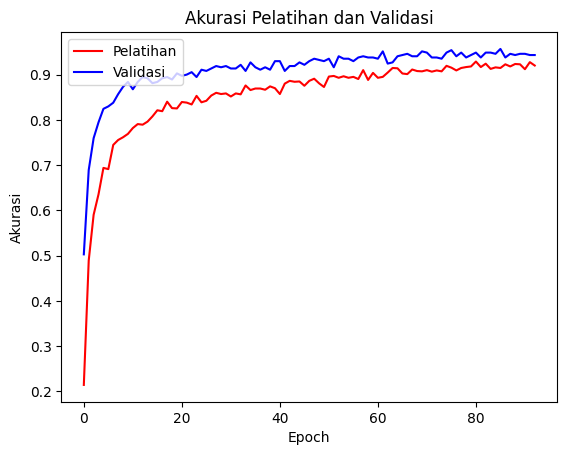

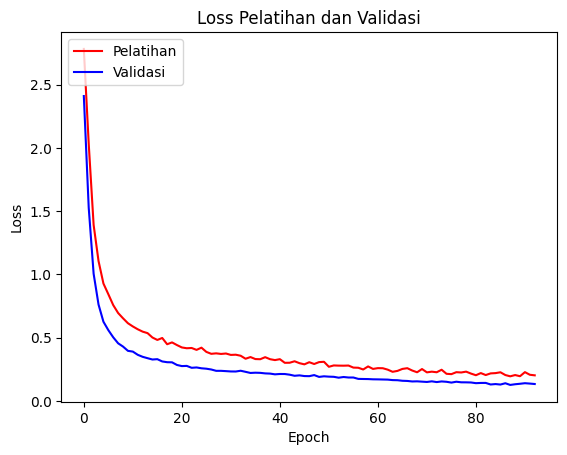

In [ ]:
# Mengambil nilai akurasi dan loss dari riwayat pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Menentukan jumlah epoch
epochs = range(len(acc))

# Plot akurasi pelatihan dan validasi
plt.plot(epochs, acc, 'r')        # Garis merah untuk akurasi pelatihan
plt.plot(epochs, val_acc, 'b')    # Garis biru untuk akurasi validasi
plt.title('Akurasi Pelatihan dan Validasi')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Pelatihan', 'Validasi'], loc='upper left')
plt.show()

# Plot loss pelatihan dan validasi
plt.plot(epochs, loss, 'r')        # Garis merah untuk loss pelatihan
plt.plot(epochs, val_loss, 'b')    # Garis biru untuk loss validasi
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Pelatihan', 'Validasi'], loc='upper left')
plt.title('Loss Pelatihan dan Validasi')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9459459459459459
Precision (macro): 0.9387379678459137
Recall (macro): 0.9360226522479183
F1 Score (macro): 0.9353232530456651

Classification Report:
               precision    recall  f1-score   support

      banana       0.96      1.00      0.98        25
   blackgram       0.93      1.00      0.96        27
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        21
      coffee       0.93      1.00      0.97        14
      cotton       0.96      1.00      0.98        22
        jute       0.87      0.95      0.91        21
 kidneybeans       0.94      1.00      0.97        17
      lentil       0.93      0.82      0.88        17
       maize       1.00      0.86      0.93        22
       mango       0.92      1.00      0.96        24
   mothbeans       0.83      0.83      0.83        12
    mungbean       1.00      1.00      1.00        29
   muskmelon       0.85      1.00      0

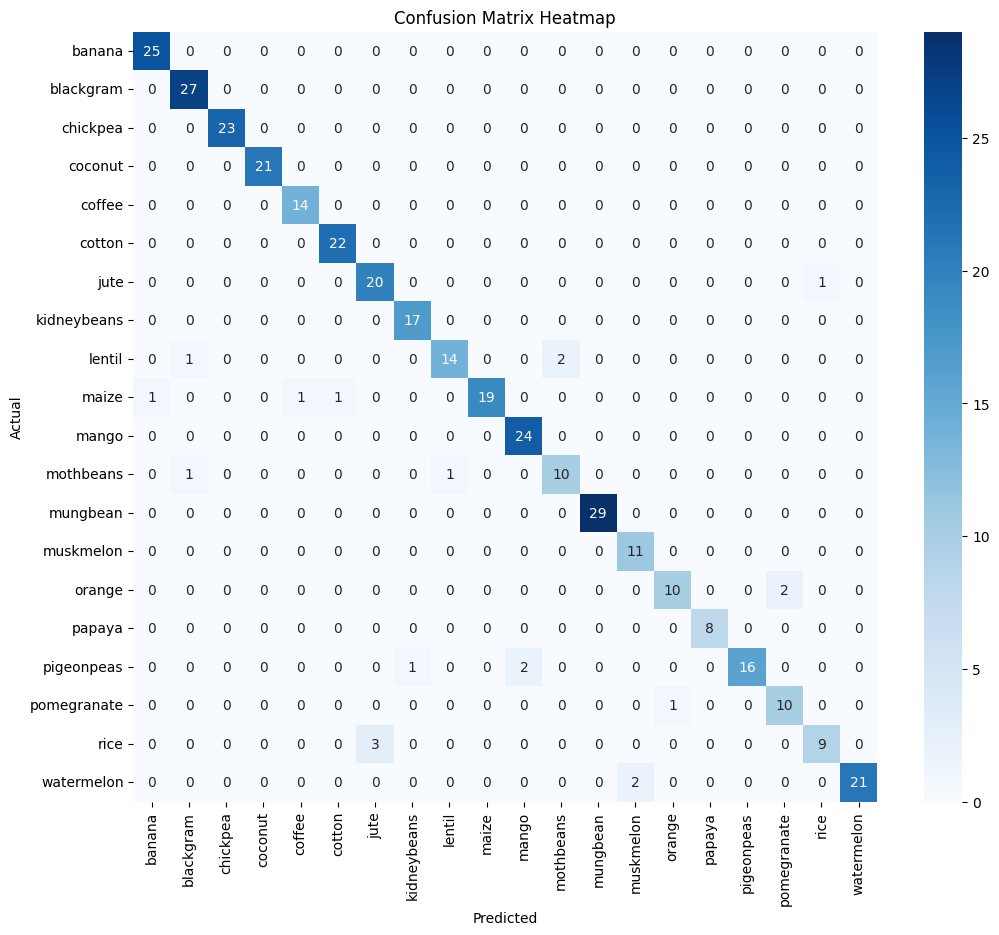

In [ ]:
# Prediksi kelas
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix + heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Inference

In [ ]:
# Fungsi sistem rekomendasi berbasis hasil klasifikasi
def classify_and_recommend(input_data, top_k=5):
    """
    input_data: list/array dengan urutan dan jumlah fitur sama seperti X
    top_k: jumlah rekomendasi tanaman yang ditampilkan
    """
    # Ubah ke DataFrame agar urutan dan fitur konsisten
    input_df = pd.DataFrame([input_data], columns=X.columns)
    input_scaled = scaler.transform(input_df)

    # Prediksi probabilitas semua kelas
    probs = model.predict(input_scaled)[0]

    # Ambil top-k kelas dengan probabilitas tertinggi
    top_indices = probs.argsort()[-top_k:][::-1]
    top_labels = le.inverse_transform(top_indices)
    top_probs = probs[top_indices] * 100  # Ubah ke persentase

    result = pd.DataFrame({
        'Recommended Crop': top_labels,
        'Confidence (%)': top_probs.round(2)
    })
    return result

# Contoh input user (harus sesuai urutan dan fitur)
user_input = {
    'N': 12,
    'temperature': 21.879744,
    'humidity': 67.15836264,
    'ph': 4.628472891,
    'rainfall': 126.9355362,
}

# Inference dan tampilkan rekomendasi dari hasil klasifikasi
recommendation_result = classify_and_recommend(user_input, top_k=5)
print(recommendation_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
  Recommended Crop  Confidence (%)
0       pigeonpeas           100.0
1      pomegranate             0.0
2            mango             0.0
3          coconut             0.0
4             rice             0.0


## Konversi Model

In [ ]:
import joblib

# Simpan model
joblib.dump(model, "crop_recommendation_model.pkl")

# Simpan scaler
joblib.dump(scaler, "scaler.pkl")

# Simpan label encoder
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']